This notebook demonstrates Kausal framework on ENSO dynamics.

References: 

- https://www.aoml.noaa.gov/phod/docs/2004_Wang_Picaut.pdf
- https://journals.ametsoc.org/view/journals/atsc/54/7/1520-0469_1997_054_0811_aeorpf_2.0.co_2.xml

In particular, we showcase how nonlinearity strength could be quantified.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors
from tqdm import tqdm

from kausal.generator import enso
from kausal.koopman import Kausal
from kausal import stats
from kausal.observables import MLPFeatures


# 1. Generate dynamics 


$$
\frac{\partial T}{\partial t} = -r T - \epsilon T^3 - \mu \alpha b_0 h 
$$

$$
\frac{\partial h}{\partial t} = \gamma T + (\gamma \mu b_0 - c) h
$$


In [3]:
# Time span
t0, t1 = 0.0, 100.0
dt = 0.01
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

# Parameters
r, alpha, b0, c, gamma = 0.25, 0.125, 2.5, 1.0, 0.75
mu = 2/3 # Coupling term
eps = 0.05 # For the damping term

# Initial condition
initial_state = torch.tensor([1.0, 1.0])

# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: enso(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution
    

# 2. Causal Koopman

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:30<00:00,  1.33it/s]


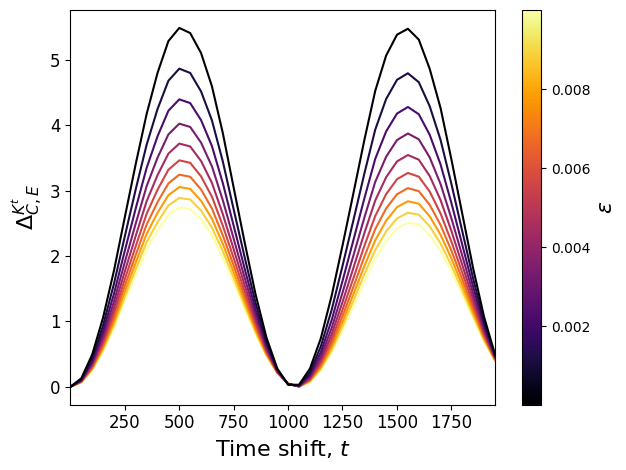

In [4]:
# Varying epsilon / nonlinearity (RFF)
time_shifts = torch.arange(1, 2000, 50)
mu = 2/3
initial_state = torch.tensor([1.0, 1.0])

epsilons = torch.linspace(1e-2, 1e-5, 10)  # Adjust the number of epsilons
cmap = cm.inferno
norm = mcolors.Normalize(vmin=epsilons.min().item(), vmax=epsilons.max().item())  # Normalize color scale

f, ax = plt.subplots()

# Causal time shift analysis
for eps in epsilons:
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T  # [T, h]

    # Causal inference (T --> h)
    causal_koopman = Kausal(
        cause=omega[0:1],
        effect=omega[1:2]
    )

    causal_effect = causal_koopman.evaluate_multistep(time_shifts=time_shifts)

    color = cmap(norm(eps.item()))  # Normalize the scalar value
    ax.plot(time_shifts.numpy(), causal_effect.numpy(), color=color)

ax.set_xlim([time_shifts[0], time_shifts[-1]])
ax.set_xlabel(r"Time shift, $t$", fontsize=16)
ax.set_ylabel(r"$\Delta^{K^t}_{C,E}$", fontsize=16)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.05)
cbar.set_label(r"$\epsilon$", fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()
f.savefig("docs/enso_estimation_rff.png", dpi=300, bbox_inches="tight");


# 3. Deep Causal Koopman

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.39it/s]


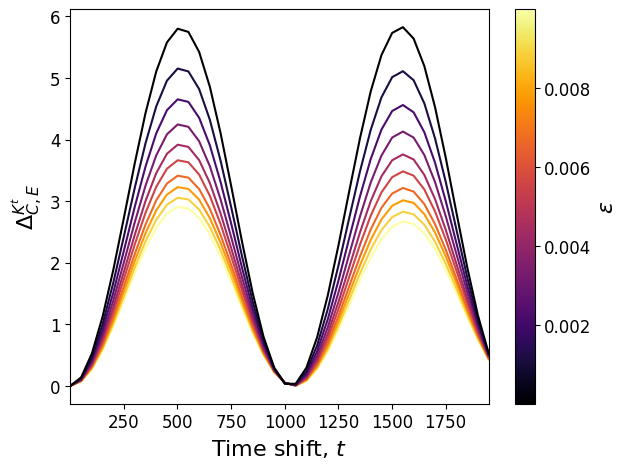

In [5]:
# Varying epsilon / nonlinearity (MLP)

# Hyperparameters
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

# Parameters
time_shifts = torch.arange(1, 2000, 50)
mu = 2/3
initial_state = torch.tensor([1.0, 1.0])

epsilons = torch.linspace(1e-2, 1e-5, 10)  # Adjust the number of epsilons
cmap = cm.inferno 
norm = mcolors.Normalize(vmin=epsilons.min().item(), vmax=epsilons.max().item())  # Normalize color scale

f, ax = plt.subplots()

# Causal time shift analysis
for eps in epsilons:
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T  # [T, h]

    # Causal inference (T --> h)
    causal_koopman = Kausal(
        marginal_observable=MLPFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable=MLPFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause=omega[0:1],
        effect=omega[1:2],
    )

    # Fit observable functions
    marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
        n_train=n_train,
        epochs=epochs,
        lr=lr,
        batch_size=n_train,
    )

    causal_effect = causal_koopman.evaluate_multistep(time_shifts=time_shifts)

    color = cmap(norm(eps.item()))  # Normalize the scalar value
    ax.plot(time_shifts.numpy(), causal_effect.numpy(), color=color)


ax.set_xlim([time_shifts[0], time_shifts[-1]])
ax.set_xlabel(r"Time shift, $t$", fontsize=16)
ax.set_ylabel(r"$\Delta^{K^t}_{C,E}$", fontsize=16)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.05)
cbar.set_label(r"$\epsilon$", fontsize=16)
cbar.ax.tick_params(labelsize=12)

plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()
f.savefig("docs/enso_estimation_mlp.png", dpi=300, bbox_inches="tight");
